Using device: cpu
Epoch 0, Total Loss: 6.475862e+00
Epoch 1000, Total Loss: 4.892600e-04
Epoch 2000, Total Loss: 1.721344e-04
Epoch 3000, Total Loss: 1.070745e-04
Epoch 4000, Total Loss: 4.289432e-05
Epoch 5000, Total Loss: 6.293153e-06
Epoch 6000, Total Loss: 3.579788e-06
Epoch 7000, Total Loss: 2.726032e-06
Epoch 8000, Total Loss: 2.194827e-06
Epoch 9000, Total Loss: 1.839978e-06
Epoch 10000, Total Loss: 2.451717e-06
Epoch 11000, Total Loss: 1.260854e-06
Epoch 12000, Total Loss: 1.017730e-06
Epoch 13000, Total Loss: 1.926442e-06
Epoch 14000, Total Loss: 7.366937e-07
Epoch 15000, Total Loss: 6.356948e-07
Epoch 16000, Total Loss: 5.902410e-07
Epoch 17000, Total Loss: 4.868057e-07
Epoch 18000, Total Loss: 4.160703e-07
Epoch 19000, Total Loss: 5.187338e-07


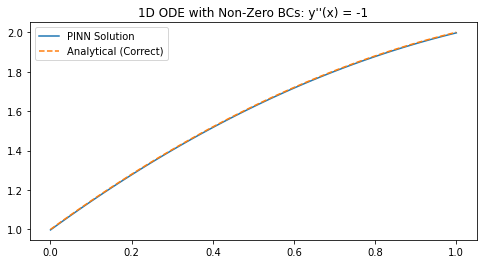

In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Title: 1D ODE with Non-Zero Boundary Conditions using PINNs

We solve the boundary value problem:
    y''(x) = -1,  x in (0,1),
with boundary conditions:
    y(0) = 1
    y(1) = 2

Correct Analytical solution:
    y(x) = -0.5*x^2 + 1.5*x + 1

PINN approach:
    - A small neural network y_theta(x) approximates y(x).
    - We compute y'(x) and y''(x) via automatic differentiation.
    - Residual: y''(x) + 1 = 0
    - Loss = MSE(residual) + MSE(y(0)-1) + MSE(y(1)-2)
"""

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class ODE_Net(nn.Module):
    """
    Simple fully-connected network for y(x).
    We'll use 3 layers: input -> hidden -> hidden -> output,
    each hidden with Tanh activation.
    """
    def __init__(self, hidden_units=20):
        super(ODE_Net, self).__init__()
        self.layer1 = nn.Linear(1, hidden_units)
        self.layer2 = nn.Linear(hidden_units, hidden_units)
        self.layer3 = nn.Linear(hidden_units, 1)
        self.activation = nn.Tanh()

    def forward(self, x):
        # x: shape (N,1)
        out = self.activation(self.layer1(x))
        out = self.activation(self.layer2(out))
        out = self.layer3(out)
        return out

def residual(model, x):
    """
    Compute the ODE residual for y''(x) + 1 = 0.
    """
    x.requires_grad_(True)
    y = model(x)
    dydx = torch.autograd.grad(
        y, x,
        grad_outputs=torch.ones_like(y),
        create_graph=True
    )[0]
    d2ydx2 = torch.autograd.grad(
        dydx, x,
        grad_outputs=torch.ones_like(dydx),
        create_graph=True
    )[0]
    res = d2ydx2 + 1.0  # y''(x) + 1 should be 0
    return res

def main():
    model = ODE_Net().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    num_epochs = 20000  # might need extra epochs for best convergence

    # Interior points
    N_interior = 50
    x_interior = torch.rand(N_interior,1, device=device)

    # Boundary points
    x_bc0 = torch.tensor([[0.0]], device=device)  # x=0 => y=1
    x_bc1 = torch.tensor([[1.0]], device=device)  # x=1 => y=2

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        # PDE residual loss
        r_int = residual(model, x_interior)
        loss_pde = torch.mean(r_int**2)

        # Boundary losses
        y_bc0 = model(x_bc0)  # Should match 1
        y_bc1 = model(x_bc1)  # Should match 2
        loss_bc0 = torch.mean((y_bc0 - 1.0)**2)
        loss_bc1 = torch.mean((y_bc1 - 2.0)**2)

        loss = loss_pde + loss_bc0 + loss_bc1
        loss.backward()
        optimizer.step()

        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, Total Loss: {loss.item():.6e}")

    # Evaluate
    model.eval()
    x_test = torch.linspace(0,1,100, device=device).unsqueeze(1)
    y_pred = model(x_test).detach().cpu().numpy().flatten()
    x_test_np = x_test.cpu().numpy().flatten()

    # Analytical solution: y(x) = -0.5*x^2 + 1.5*x + 1
    y_true = -0.5*x_test_np**2 + 1.5*x_test_np + 1.0

    # Plot
    plt.figure(figsize=(8,4))
    plt.plot(x_test_np, y_pred, label="PINN Solution")
    plt.plot(x_test_np, y_true, '--', label="Analytical (Correct)")
    plt.legend()
    plt.title("1D ODE with Non-Zero BCs: y''(x) = -1")
    plt.show()

if __name__ == "__main__":
    main()
